In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import collections
import torch.distributions as tdists
import math
import wandb
import matplotlib
from tabular_dataset import TabularDataset
import seaborn as sns
import scipy.stats as ss

# Pre-processing aero data
import pandas as pd
from sklearn import preprocessing as skpp
from sklearn import model_selection as model



plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

LabelledData = collections.namedtuple("LabelledData",["x","y"])

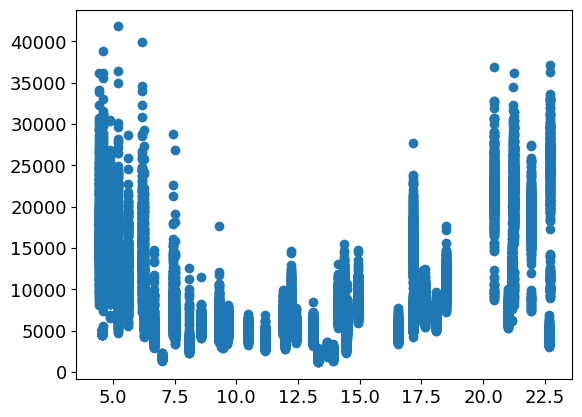

In [102]:
df_train = pd.read_csv("raw_data/aero/train/data_raw.dat", header = 0, index_col = 0)
aero_train = df_train[["URef", "PLExp", "IECturbc", "TwrBsMxt_[kN-m] ST_DEL"]]
aero_train_mean = aero_train.mean()
# aero_train_mean.head
aero_train_std = aero_train.std()

aero_train_scale = (aero_train - aero_train_mean)/aero_train_std
# aero_train_scale.tail()

aero_train_split, aero_val_split = model.train_test_split(aero_train_scale, test_size=0.3, random_state=42)
# np.savetxt("train.csv", aero_train_split,delimiter=",")
# np.savetxt("val.csv", aero_val_split,delimiter=",")

df_test = pd.read_csv("raw_data/aero/test/data_raw.dat", header = 0, index_col = 0)
plt.figure()
plt.scatter(df_test["URef"],df_test["TwrBsMxt_[kN-m] ST_DEL"])

Text(0.5, 1.0, 'x=[9.38042967e+00 4.97845485e-05 1.90881195e+01]')

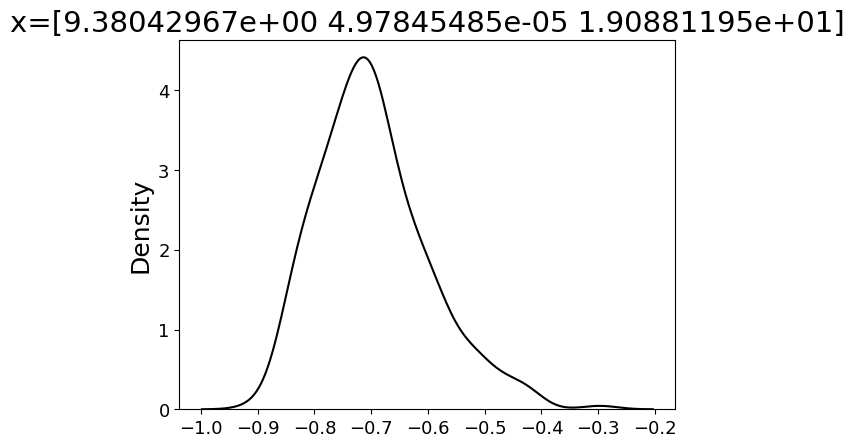

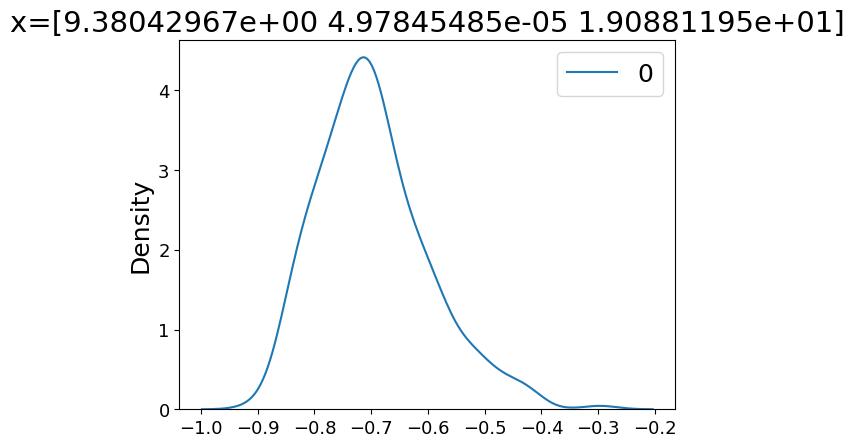

In [111]:
aero_test = df_test.loc[:, ["URef", "PLExp", "IECturbc", "TwrBsMxt_[kN-m] ST_DEL"]]
aero_test_scale = (aero_test-aero_train_mean)/aero_train_std
aero_test_scale.head()
# np.savetxt("test.csv", aero_test_scale,delimiter=",")
# tmp = np.genfromtxt("test.csv", delimiter = ",")

test_scale = LabelledData(x= aero_test_scale.to_numpy()[:,:3],y = aero_test_scale.to_numpy()[:,3:])
test = LabelledData(x= aero_test.to_numpy()[:,:3],y = aero_test.to_numpy()[:,3:])


i1 = 0
i2 = 100
x_value = test_scale.x[i1]
x_value2 = test_scale.x[i2]# 645,

# Get list of indexes associated with same data
def indexes(val, x):
    listofindexes = []
    for i in range(len(x)):
        if (x[i] == val).all():
            listofindexes.append(i)
    return listofindexes

idx = indexes(x_value,test_scale.x)
idx2 = indexes(x_value2,test_scale.x)
plt.figure()
sns.kdeplot(test_scale.y[idx].squeeze(), color='k')
plt.title('x={}'.format(test.x[i1]))

plt.figure()
sns.kdeplot(test_scale.y[idx2])
plt.title('x={}'.format(test.x[i2]))

In [100]:
listofx = np.linspace(0,14700,50, dtype=int)

DATASET_PATH = './datasets'
DATASET_NAME = 'aero'
TESTPDF_DIR = 'testpdf_imgs'
testpdf_imgs_path = os.path.join(DATASET_PATH, DATASET_NAME,TESTPDF_DIR)
if not os.path.exists(testpdf_imgs_path):
    os.makedirs(testpdf_imgs_path)
assert os.path.exists(testpdf_imgs_path),("dataset folder {} does not exist".format(testpdf_imgs_path))

for i, idx in enumerate(listofx):
    # print(i, idx)
    tmp = indexes(test_scale.x[idx], test_scale.x)
    plt.figure()
    sns.kdeplot(test_scale.y[tmp].squeeze(), color='k')
    plt.title('x={}, idx = {}'.format(test.x[idx], idx), fontsize=10)
    
    plt.savefig('{}/{}.png'.format(testpdf_imgs_path, idx))
    plt.close()

In [7]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'aero'
IMGS_PATH = './images'

dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

if not os.path.exists(IMGS_PATH):
    os.makedirs(IMGS_PATH)

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
data_xdim = 3
data_ydim = 1
scatter_plot = 0

for split in ("train","test","val"):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k')
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        plt.show()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:data_xdim],y=torch_data[:,data_xdim:])

train_data = splits["train"]
val_data = splits['val']
test_data = splits['test']

In [8]:
train_tab = TabularDataset(train_data)
train_tab[0]

(tensor([-0.7698,  0.3584, -0.1038]), tensor([-0.9621]))

In [9]:
#create NN classes for discrimator/generator
def ffsection(x_dim, other_dim, layer_list, extra_in_hidden_dim=0):
    if not layer_list:
        layers = []
        out_dim = x_dim+extra_in_hidden_dim
    else:
        layers = [nn.Linear(x_dim + other_dim, layer_list[0])]+\
            [nn.Linear(from_dim+extra_in_hidden_dim, to_dim) \
            for from_dim, to_dim in zip(layer_list[:-1], layer_list[1:])]
    out_dim = layer_list[-1]
    return nn.ModuleList(layers), out_dim

class NoiseInjection(nn.Module):
    def __init__(self, nn_spec) -> None:
        super().__init__()
        self.activation = nn_spec["activation"]#relu
        self.nodes_per_layer = nn_spec["nodes_per_layer"]#[64, 64, 64, 64, 64, 64]
        self.other_dim = nn_spec["other_dim"]#5,#noise dimensions
        self.cond_dim = nn_spec["cond_dim"]# 1 #data_xdim
        self.output_dim = nn_spec["output_dim"]#1 #data_ydim

        self.layers, self.last_layer_dim = ffsection(
            self.cond_dim, self.other_dim, self.nodes_per_layer, self.other_dim)
        self.output_layer = nn.Linear((self.last_layer_dim+self.other_dim),self.output_dim)
        
    def forward(self, x):
        hidden_repr = x[:,:self.cond_dim]
        noise = x[:,self.cond_dim:]
        for layer in self.layers:
            combined_repr = torch.cat((hidden_repr, noise), dim = 1)
            hidden_repr = self.activation(layer(combined_repr))
        
        hidden_repr = torch.cat((hidden_repr, noise),dim =1)    
        return self.output_layer(hidden_repr)
class FeedForward(nn.Module):
    def __init__(self, nn_spec) -> None:
        super().__init__()
        self.activation = nn_spec["activation"]
        self.nodes_per_layer = nn_spec["nodes_per_layer"]
        self.other_dim = nn_spec["other_dim"]
        self.cond_dim = nn_spec["cond_dim"]
        self.output_dim = nn_spec["output_dim"]

        self.layers, self.last_layer_dim = ffsection(
            self.cond_dim, self.other_dim, self.nodes_per_layer)
        self.output_layer = nn.Linear(self.last_layer_dim,self.output_dim)
    def forward(self, x):        
        for layer in self.layers:
            x = self.activation(layer(x))
        return self.output_layer(x)#no activation fnc before output
class DoubleInputNetwork(nn.Module):
    def __init__(self, nn_spec) -> None:
        super().__init__()

        self.activation = nn_spec["activation"]
        self.dim_x = nn_spec["cond_dim"]
        
        self.cond_layers, cond_dim = ffsection(nn_spec["cond_dim"], other_dim= 0,
                                               layer_list= nn_spec["cond_layers"])
        self.other_layers, other_dim = ffsection(x_dim = 0,other_dim = nn_spec["other_dim"],
                                                 layer_list=nn_spec["other_layers"])
        self.hidden_layers, hidden_dim = ffsection(cond_dim, other_dim,
                                                    nn_spec["nodes_per_layer"])
        self.output_layer = nn.Linear(hidden_dim, nn_spec["output_dim"])

    def forward(self, x):
        cond_repr = x[:,:self.dim_x]
        other_repr = x[:,self.dim_x:]

        #conditional input
        for layer in self.cond_layers:
            cond_repr = self.activation(layer(cond_repr))
        #other (noise/real data)
        for layer in self.other_layers:
            other_repr = self.activation(layer(other_repr))
        
        hidden_input = torch.cat((cond_repr, other_repr), dim = 1)
        for layer in self.hidden_layers:
            hidden_input = self.activation(layer(hidden_input))

        output = self.output_layer(hidden_input)
        return output


In [10]:
class CGAN:
    def __init__(self, config, nn_spec) -> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu" 
        self.bce_logits = nn.BCEWithLogitsLoss(reduction="mean")
        self.disc = nn_spec['disc_spec']['type'](nn_spec['disc_spec']).to(self.device)
        self.gen = nn_spec['gen_spec']['type'](nn_spec['gen_spec']).to(self.device)
        self.config = config
        self.kernel_scale = None
        self.val_ll = []
        self.train_ll = []
        self.epoch_ll = []
        self.discriminator_loss = []
        self.discriminator_loss_data = []
        self.discriminator_loss_gen = []
        self.generator_loss = []
        self.fooling = []
        self.nn_spec = nn_spec

    def train(self, train_data, val_func):
        train_tab = TabularDataset(train_data)
        n_samples = len(train_tab)
        train_loader = torch.utils.data.DataLoader(train_tab,
                                                    batch_size = self.config["num_batches"],
                                                    shuffle = True,
                                                    num_workers = 4)
        self.gen.train()
        self.disc.train()

        best_11 = None #best validation log-likelihood
        best_mae = None
        best_epoch_i = None
        val_ll = []
        train_ll = []
        epoch_ll = []
        best_save_path = os.path.join("./",
                            "epoch_best.pt") # Path to save best params to

        gen_opt = torch.optim.RMSprop(self.gen.parameters(),lr = self.config["gen_lr"])
        disc_opt = torch.optim.RMSprop(self.disc.parameters(), lr = self.config["disc_lr"])
        for epoch in range(self.config["epochs"]):
            epoch_disc_loss = []
            epoch_gen_loss = []
            epoch_fooling = []
            for n_batch, (x_batch, data_batch) in enumerate(train_loader):
                batch_size = data_batch.shape[0]

                x_batch = x_batch.to(self.device)
                data_batch = data_batch.to(self.device)

                disc_opt.zero_grad()

                noise_batch = self.get_gaussian().sample([batch_size]).to(self.device)
                
                #Sample from generator
                gen_input = torch.cat((x_batch, noise_batch), dim = 1)
                gen_output = self.gen(gen_input)
                #Train discriminator
                data_logits = self.disc(torch.cat((x_batch, data_batch), dim = 1))
                gen_logits = self.disc(torch.cat((x_batch,gen_output), dim = 1))
                disc_loss = self.disc_loss(gen_logits, data_logits)
                disc_loss.backward()
                disc_opt.step()

                #train generator
                gen_opt.zero_grad()
                n_gen_samples = batch_size
                new_noise_batch = self.get_gaussian().sample([n_gen_samples]).to(self.device)

                new_gen_input = torch.cat((x_batch,new_noise_batch),dim = 1)
                new_gen_batch = self.gen(new_gen_input)
                new_gen_logits = self.disc(torch.cat((x_batch,new_gen_batch),dim = 1))
                gen_loss = self.gen_loss(new_gen_logits) 
                gen_loss.backward()
                gen_opt.step()

                batch_fooling = torch.mean(torch.sigmoid(new_gen_logits))
                epoch_fooling.append(batch_fooling.item())
                epoch_disc_loss.append(disc_loss.item())
                epoch_gen_loss.append(gen_loss.item())

            self.discriminator_loss.append(np.mean(epoch_disc_loss))
            self.generator_loss.append(np.mean(epoch_gen_loss))
            self.fooling.append(np.mean(epoch_fooling))

            if val_func and ((epoch+1) % self.config["val_interval"] == 0):
                evaluation_vals, evaluation_vals_train = val_func(self, epoch)
                tmp = evaluation_vals["ll"]
                tmp2 = evaluation_vals_train["ll"]
                self.val_ll.append(tmp)                
                self.train_ll.append(tmp2)
                self.epoch_ll.append(epoch+1)
                if (best_epoch_i==None) or evaluation_vals["ll"] > best_ll:
                    best_ll = evaluation_vals["ll"]
                    best_mae = evaluation_vals["mae"]
                    best_epoch_i = epoch
                    model_params = {
                        "gen": self.gen.state_dict(),
                        "disc": self.disc.state_dict(),
                    }
                    torch.save(model_params, best_save_path)
        
        self.epoch_disc_loss = epoch_disc_loss
        self.epoch_gen_loss = epoch_gen_loss
        self.epoch_fooling = epoch_fooling
        plt.figure()
        plt.plot(self.epoch_ll,self.val_ll, label = "val ll")
        plt.plot(self.epoch_ll,self.train_ll, label = "train ll")
        plt.title("history")
        plt.legend()
        images_save_path = os.path.join(IMGS_PATH,"./history.png")
        plt.savefig(images_save_path)

        plt.figure()
        plt.plot(self.discriminator_loss, label = 'disc loss')
        plt.plot(self.generator_loss, label = "gen_loss")
        plt.title('generator/discriminator loss')
        plt.legend() 

        plt.figure()
        plt.plot(self.fooling, label='fooling')
        plt.legend()
        plt.title('Fooling')       
        print("best ll:%g",best_ll)
        print("best mae:%g",best_mae)
        print("best epoch:%g",best_epoch_i)
        checkpoint = torch.load(best_save_path, map_location=self.device)
        self.disc.load_state_dict(checkpoint["disc"])
        if "gen" in checkpoint:
            self.gen.load_state_dict(checkpoint["gen"])

    def gen_loss(self, gen_logits):
        return self.bce_logits(gen_logits, torch.ones_like(gen_logits))
    def disc_loss(self, gen_logits, data_logits):
        
        disc_loss_gen = self.bce_logits(gen_logits,torch.zeros_like(gen_logits))
        disc_loss_data = self.bce_logits(data_logits, torch.ones_like(data_logits))
        disc_loss = disc_loss_gen+disc_loss_data
        return disc_loss
        
    def get_gaussian(self):
        return tdists.multivariate_normal.MultivariateNormal(
                torch.zeros(self.config["noise_dim"], device=self.device),
                torch.eye(self.config["noise_dim"], device=self.device)
            ) #isotropic 

    @torch.no_grad()
    def eval(self, dataset, kde_eval, use_best_kernel_scale=False):
        ks = None

        if use_best_kernel_scale:
            assert self.kernel_scale, "No kernel scale stored in class CGAN"
            ks = self.kernel_scale
        evaluation_vals, best_kernel_scale = kde_eval(self, dataset, kernel_scale = ks)
        self.kernel_scale = best_kernel_scale
        return evaluation_vals

    @torch.no_grad()
    def sample(self, x, batch_size = None, fixed_noise=False):
        n_samples = x.shape[0]
        x = x.to(self.device)

        noise_sample = self.get_gaussian().sample([n_samples]).to(self.device)

        if batch_size and n_samples > batch_size:
            batch_iterator = zip(torch.split(x, batch_size,dim=0),
                                 torch.split(noise_sample, batch_size, dim=0))
            sample_list = []
            for x_batch, noise_batch in batch_iterator:
                gen_input = torch.cat((x_batch, noise_batch), dim = 1)
                sample_batch = self.gen(gen_input)
                sample_list.append(sample_batch)
            samples = torch.cat(sample_list, dim = 0)
        else:
            gen_input = torch.cat((x,noise_sample), dim = 1)
            samples = self.gen(gen_input)
        return samples


In [11]:
class PearsonCGAN(CGAN):
    def disc_loss(self, gen_logits, data_logits):
        return torch.mean(-1.*data_logits) +\
            torch.mean(gen_logits*(0.25*gen_logits + 1.0))           
    def gen_loss(self, gen_logits):
        return torch.mean(-1*gen_logits)
class LSCGAN(CGAN):
    def disc_loss(self, gen_logits, data_logits):
        return 0.5*(nn.functional.mse_loss(data_logits, torch.ones_like(data_logits))
                + nn.functional.mse_loss(gen_logits, torch.zeros_like(gen_logits)))
    def gen_loss(self, gen_logits):
        return 0.5*nn.functional.mse_loss(gen_logits, torch.ones_like(gen_logits))

In [12]:
def evaluate_model(model, data, data_train, epoch=None, make_plots = True):
    testing = (epoch==None) #returns False/0 if epoch is not None
    config = model.config
    evaluation_vals = model.eval(data, kde_eval, use_best_kernel_scale=testing)
    val_method = "true"
    metric_string = "\t".join(["{}: {:.5}".format(key, validation_val) for
        (key,validation_val) in evaluation_vals.items()])
    print("Epoch {}, {}\t{}".format(epoch, val_method, metric_string))

    tmp = data.x.shape[0]
    data_train_partial = LabelledData(x=data_train.x[:tmp], y=data_train.y[:tmp])
    evaluation_vals_train = model.eval(data_train_partial, kde_eval, use_best_kernel_scale = testing)
    metric_string = "\t".join(["{}: {:.5}".format(key, training_val) for
        (key,training_val) in evaluation_vals_train.items()])
    # print("Training Epoch {}, {}\t{}".format(epoch, val_method, metric_string))
    
    if make_plots:
        if config["scatter"]:
            model_samples = model.sample(data.x, batch_size = config["eval_batch_size"])
            if type(model_samples) == torch.Tensor:
                model_samples = model_samples.to("cpu")
            model_data = LabelledData(x=data.x, y = model_samples)
            plot_title = 'Training epoch {}'.format(epoch)
            sample_sets = [data, model_data]
            labels = ["Ground Truth", "model"]
            plot_samples(sample_sets, file_name = epoch,
                        labels = labels, title=plot_title, range_dataset=data)
                      
    return evaluation_vals, evaluation_vals_train 

def mae_from_samples(samples, y):
    medians,_ = torch.median(samples, dim=1)
    abs_errors = torch.sum(torch.abs(medians-y), dim = 1)
    return torch.mean(abs_errors).item()

def kde_eval(model, data, kernel_scale=None):
    x = data.x.to(model.device)
    x_repeated = torch.repeat_interleave(x, repeats = model.config["eval_samples"], dim = 0)
    shape_y = data.y.shape
    # print(shape_y)
    # print(samples.shape)
    samples = model.sample(x_repeated, batch_size = model.config["eval_batch_size"]).reshape(
        shape_y[0],model.config["eval_samples"],shape_y[1])
    y = data.y.to(model.device)
    diff = samples - y.unsqueeze(1)
    squarednorm = torch.sum(torch.pow(diff,2), dim = 2)

    if not (kernel_scale == None):
        n_h = 1
        h_squared = torch.tensor([kernel_scale], device = model.device)
    else:
        n_h = model.config["kernel_scales"]
        h_squared = torch.logspace(
            math.log10(model.config["kernel_scale_min"]),
            math.log10(model.config["kernel_scale_max"]), steps = n_h)
    h_squared = h_squared.to(model.device)
    scale_lls = []
    #Batch over kernel scales
    h_squared_splits = torch.split(h_squared, model.config["kde_batch_size"], dim = 0)

    for splits in h_squared_splits:
        normalisation = torch.pow(torch.rsqrt(2.*math.pi*splits), data_ydim)
        ratio = squarednorm.unsqueeze(dim=2).repeat((1,1,splits.shape[0]))/splits

        ll_y = torch.log(normalisation)+torch.logsumexp(-0.5*(ratio), dim = 1)-\
                math.log(model.config["eval_samples"])
        mean_lls = torch.mean(ll_y, dim = 0)
        scale_lls.append(mean_lls)
    joined_scale_lls = torch.cat(scale_lls, dim = 0)

    argmax = torch.argmax(joined_scale_lls)
    best_scale = h_squared[argmax]
    
    best_ll = joined_scale_lls[argmax].item()
    best_mae = mae_from_samples(samples, y)
    evaluation_vals = {
        "ll": best_ll,
        "mae": best_mae
    }

    return evaluation_vals, best_scale

def val_func(model, epoch):
    return evaluate_model(model, data = val_data, data_train=train_data, epoch = epoch)

def plot_samples(sample_sets, file_name, labels=None, range_dataset=None,
        title=None, both_y=False):
    n_sets = len(sample_sets)
    fig, axes = plt.subplots(nrows=1, ncols=n_sets, squeeze=False,
            figsize=(7.*n_sets, 4.5))
    x_range = (min(range_dataset.x), max(range_dataset.x))
    y_range = (min(range_dataset.y), max(range_dataset.y))
    for set_i, (samples, ax) in enumerate(zip(sample_sets, axes[0])):
        ax.scatter(samples.x, samples.y, s=3, color="green")
    
        ax.set_xlim(*x_range)
        ax.set_ylim(*y_range)

        if labels:
            ax.set(title=labels[set_i])
        if both_y:
            ax.set(xlabel="$y_1$", ylabel="$y_2$")
        else:
            ax.set(xlabel="$x$", ylabel="$y$")
    if title:
        fig.suptitle(title)

    fig.tight_layout()
    plot_path = os.path.join(IMGS_PATH,"{}.png".format(file_name))
    plt.savefig(plot_path)
    plt.close(fig)


In [13]:
#get samples from trained model
def get_samples(model,input):
    input = torch.tensor(input, dtype = torch.float)
    input_repeated = input.repeat(1000,1)
    samples = model.sample(input_repeated, batch_size = 1000)    
    return samples.cpu()

Epoch 19, true	ll: -0.90623	mae: 0.40454
Epoch 39, true	ll: -0.79395	mae: 0.3926
Epoch 59, true	ll: -0.70544	mae: 0.3986
Epoch 79, true	ll: -0.65274	mae: 0.39034
Epoch 99, true	ll: -0.44913	mae: 0.34297
Epoch 119, true	ll: -0.45985	mae: 0.34043
Epoch 139, true	ll: -0.48492	mae: 0.34364
Epoch 159, true	ll: -0.60423	mae: 0.37314
Epoch 179, true	ll: -0.41744	mae: 0.32619
Epoch 199, true	ll: -0.35678	mae: 0.31861
Epoch 219, true	ll: -0.28135	mae: 0.30406
Epoch 239, true	ll: -0.33723	mae: 0.31305
Epoch 259, true	ll: -0.24424	mae: 0.30454
Epoch 279, true	ll: -0.66975	mae: 0.42404
Epoch 299, true	ll: -0.4072	mae: 0.34811
Epoch 319, true	ll: -0.14688	mae: 0.29383
Epoch 339, true	ll: -0.88335	mae: 0.49467
Epoch 359, true	ll: -0.12012	mae: 0.27833
Epoch 379, true	ll: -0.15015	mae: 0.28
Epoch 399, true	ll: -0.083384	mae: 0.28045
Epoch 419, true	ll: -0.12937	mae: 0.28133
Epoch 439, true	ll: -0.24983	mae: 0.29545
Epoch 459, true	ll: -0.23111	mae: 0.2921
Epoch 479, true	ll: -0.17711	mae: 0.29829
Epo

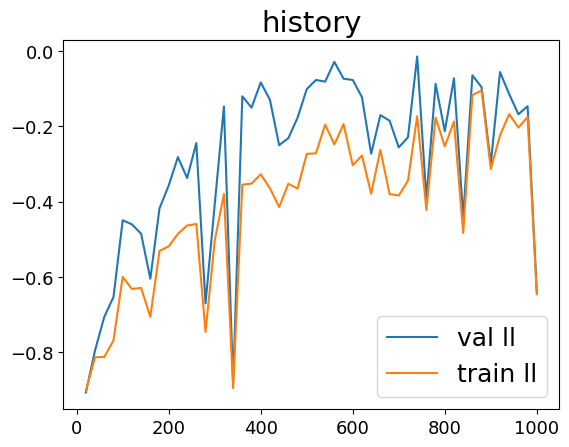

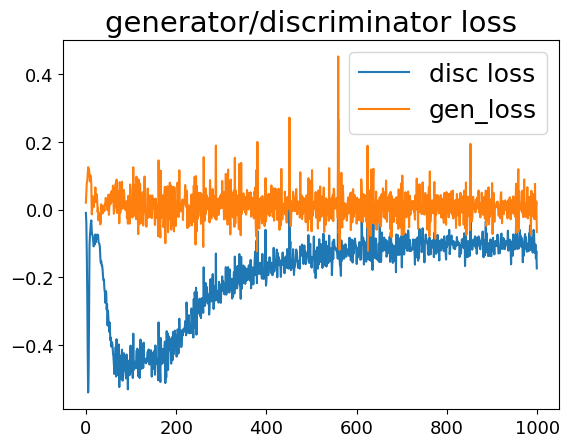

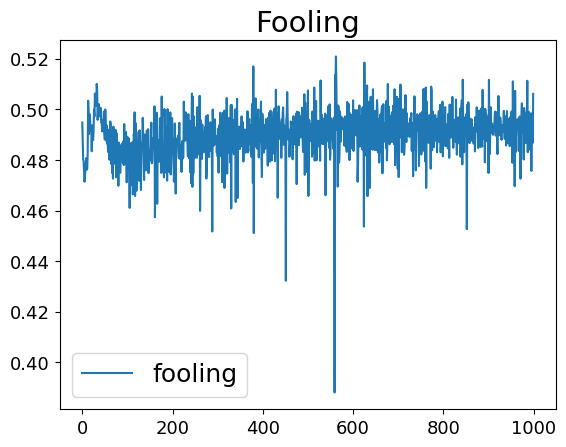

In [18]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 10,
    "epochs": 1000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": DoubleInputNetwork
}
}
cgan_model_Pearson = PearsonCGAN(config, nn_spec)
cgan_model_Pearson.train(train_data,val_func)

In [136]:
x_values, x_values_index = np.unique(test_scale.x, axis = 0, return_index=True)
sort =np.argsort(x_values_index)
x_values = x_values[sort]
x_values_index = x_values_index[sort]

DATASET_PATH = './datasets'
DATASET_NAME = 'aero'
SAMPLEPDF_DIR = 'sample_pdf_imgs'
samplepdf_imgs_path = os.path.join(DATASET_PATH, DATASET_NAME,SAMPLEPDF_DIR)
if not os.path.exists(samplepdf_imgs_path):
    os.makedirs(samplepdf_imgs_path)
assert os.path.exists(samplepdf_imgs_path),("dataset folder {} does not exist".format(samplepdf_imgs_path))

for i, (idx,values) in enumerate(zip(x_values_index, x_values)):
    samples = get_samples(cgan_model_Pearson, values)
    plt.figure()
    sns.kdeplot(samples.squeeze(), color ='b', label='Gen')
    tmp = indexes(test_scale.x[idx], test_scale.x)

    sns.kdeplot(test_scale.y[tmp].squeeze(), color='k', label='True')
    plt.title('x={}'.format(values), fontsize=10)    
    plt.tight_layout()
    plt.legend()
    plt.savefig('{}/{}.png'.format(samplepdf_imgs_path, i))
    plt.close()





<AxesSubplot:ylabel='Density'>

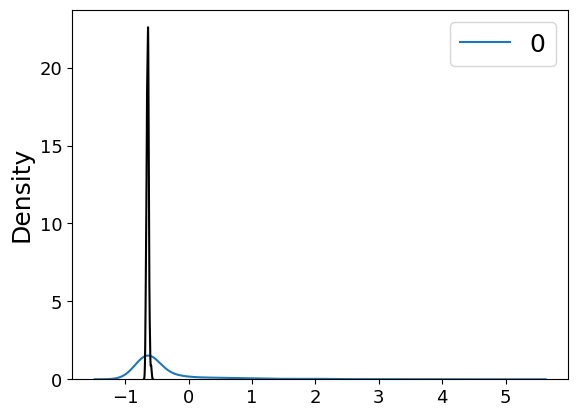

In [140]:
samples = get_samples(cgan_model_Pearson,test_scale.x[14700])
plt.figure()
sns.kdeplot(samples)
sns.kdeplot(test_scale.y[14700:].squeeze(), color ='k')
# plt.title('x={}'.format(test.x[i1]))
# samples2 = get_samples(cgan_model_Pearson,x_value2)
# plt.figure()
# sns.kdeplot(samples2, color='k')
# sns.kdeplot(test_scale.y[idx2], fill=True)
# plt.title('x={}'.format(test.x[i2]))